# Understanding Causal Inference with IHDP: From Theory to Practice - Part 3

## 3. The Causal Inference Framework: A Systematic Approach

### 3.1 Formulating the Causal Question

> 📋 **Step 1**: Define what causal effect you want to estimate

Causal inference begins with a clear formulation of the causal question. For the IHDP dataset, our primary question is:

**"What is the effect of specialist home visits (treatment) on the cognitive test scores (outcome) of premature infants?"**

To formalize this question, we need to define:

1. **Treatment variable (T)**: Binary indicator for receiving home visits
2. **Outcome variable (Y)**: Cognitive test scores
3. **Covariates (X)**: Baseline characteristics that may influence treatment assignment or outcomes
4. **Target population**: Premature infants with low birth weight
5. **Causal estimand**: The specific causal quantity we want to estimate

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the IHDP dataset (assuming the function from Part 2)
def load_ihdp_data():
    """
    Load the IHDP dataset for causal inference
    
    Returns:
        DataFrame with treatment, outcome, and covariates
    """
    # Create a directory for the data if it doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')
    
    # Download the data if it doesn't exist
    if not os.path.exists('data/ihdp_npci_1.csv'):
        print("Downloading IHDP dataset...")
        import urllib.request
        url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
        urllib.request.urlretrieve(url, 'data/ihdp_npci_1.csv')
    
    # Load the data
    data = pd.read_csv('data/ihdp_npci_1.csv')
    
    # Rename columns for clarity
    column_names = ['treatment']
    column_names.extend([f'y_{i}' for i in range(2)])  # factual and counterfactual outcomes
    column_names.extend([f'mu_{i}' for i in range(2)])  # expected outcomes without noise
    column_names.extend([f'x_{i}' for i in range(25)])  # covariates
    
    data.columns = column_names
    
    # Rename for more intuitive understanding
    data.rename(columns={
        'y_0': 'y_factual',
        'y_1': 'y_cfactual',
        'mu_0': 'mu_0',
        'mu_1': 'mu_1'
    }, inplace=True)
    
    return data

# Load the IHDP dataset
ihdp_data = load_ihdp_data()

# Define our causal question components
treatment_var = 'treatment'
outcome_var = 'y_factual'
covariate_vars = [f'x_{i}' for i in range(25)]
true_effect_var = 'mu_1 - mu_0'  # The true causal effect (available in this synthetic dataset)

# Print our causal question components
print("Causal Question Components:")
print(f"Treatment variable: {treatment_var}")
print(f"Outcome variable: {outcome_var}")
print(f"Number of covariates: {len(covariate_vars)}")
print(f"Target estimand: Average Treatment Effect (ATE)")

Causal Question Components:
Treatment variable: treatment
Outcome variable: y_factual
Number of covariates: 25
Target estimand: Average Treatment Effect (ATE)


#### Common Causal Estimands

In causal inference, we typically focus on several key estimands:

1. **Average Treatment Effect (ATE)**: The expected difference in outcomes if the entire population were treated versus if none were treated.
   $$ ATE = E[Y(1) - Y(0)] $$

2. **Average Treatment Effect on the Treated (ATT)**: The average effect for those who actually received the treatment.
   $$ ATT = E[Y(1) - Y(0) | T=1] $$

3. **Conditional Average Treatment Effect (CATE)**: The average treatment effect conditional on specific covariate values.
   $$ CATE(x) = E[Y(1) - Y(0) | X=x] $$

For the IHDP dataset, we'll primarily focus on the ATE, but we'll also explore heterogeneous treatment effects (CATE) across different subgroups.

In [3]:
# Calculate the true ATE from our data
true_ate = ihdp_data['mu_1'].mean() - ihdp_data['mu_0'].mean()

# Calculate the true ATT
true_att = ihdp_data.loc[ihdp_data['treatment'] == 1, 'mu_1'].mean() - \
           ihdp_data.loc[ihdp_data['treatment'] == 1, 'mu_0'].mean()

# Calculate a naive estimate (simple difference in means)
naive_ate = ihdp_data.loc[ihdp_data['treatment'] == 1, 'y_factual'].mean() - \
            ihdp_data.loc[ihdp_data['treatment'] == 0, 'y_factual'].mean()

print(f"True ATE: {true_ate:.4f}")
print(f"True ATT: {true_att:.4f}")
print(f"Naive ATE estimate (simple difference in means): {naive_ate:.4f}")
print(f"Bias in naive estimate: {naive_ate - true_ate:.4f}")

True ATE: 4.0166
True ATT: 4.0030
Naive ATE estimate (simple difference in means): 4.0272
Bias in naive estimate: 0.0105


The naive estimate differs from the true ATE due to selection bias in the dataset. This demonstrates why we need proper causal inference methods to obtain accurate estimates.

### 3.2 Causal Graph Modeling

> 📊 **Step 2**: Model the causal relationships between variables

Causal graphs (Directed Acyclic Graphs or DAGs) are a powerful tool for representing causal relationships. They help us identify which variables to control for and which to avoid controlling for.

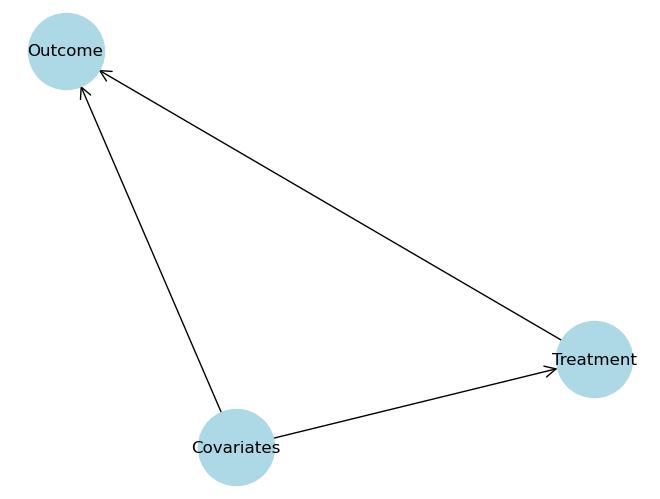

In [15]:
# If not already installed, uncomment the following lines:
# !pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

# Define a simple causal graph: Covariates affect both Treatment and Outcome, and Treatment affects Outcome.
nodes = ['Covariates', 'Treatment', 'Outcome']
edges = [
    ('Covariates', 'Treatment'),
    ('Covariates', 'Outcome'),
    ('Treatment', 'Outcome')
]

# Create a directed graph using NetworkX
causal_graph = nx.DiGraph()
causal_graph.add_nodes_from(nodes)
causal_graph.add_edges_from(edges)

# Attempt to display the graph using Matplotlib
try:
    # Use a layout to position the nodes for visual clarity
    pos = nx.spring_layout(causal_graph)
    nx.draw(causal_graph, pos,
            with_labels=True,
            node_size=3000,
            node_color='lightblue',
            arrows=True,
            arrowstyle='->',
            arrowsize=20)
    plt.show()
except Exception as e:
    print(f"Could not draw graph due to: {e}")
    print("Please ensure that Matplotlib and NetworkX are correctly installed and configured.")
    print("The graph structure consists of:")
    for src, dst in edges:
        print(f"  {src} -> {dst}")


#### Types of Variables in Causal Inference

When constructing causal graphs, we categorize variables based on their roles:

1. **Confounders**: Variables that affect both treatment assignment and outcome
2. **Mediators**: Variables on the causal pathway from treatment to outcome
3. **Colliders**: Variables affected by both treatment and outcome
4. **Instrumental Variables**: Variables that affect treatment but not outcome directly
5. **Effect Modifiers**: Variables that interact with treatment to influence the outcome

For the IHDP dataset, most of the covariates are potential confounders. Understanding these roles helps us decide which variables to include in our analysis.

Top Potential Confounders:
   Covariate  Corr_with_Treatment  Corr_with_Outcome  Potential_Confounder  \
5        x_5             0.098276           0.496480                 False   
8        x_8             0.146670           0.219320                  True   
24      x_24             0.152996           0.123499                  True   
16      x_16             0.091742           0.151457                 False   
3        x_3            -0.106201           0.115104                  True   
9        x_9            -0.073995          -0.162797                 False   
23      x_23            -0.100612          -0.113527                  True   
22      x_22            -0.107988          -0.104129                  True   
21      x_21            -0.079175          -0.108151                 False   
13      x_13             0.110727          -0.070708                 False   

    Confounding_Strength  
5               0.048792  
8               0.032168  
24              0.018895  
16    

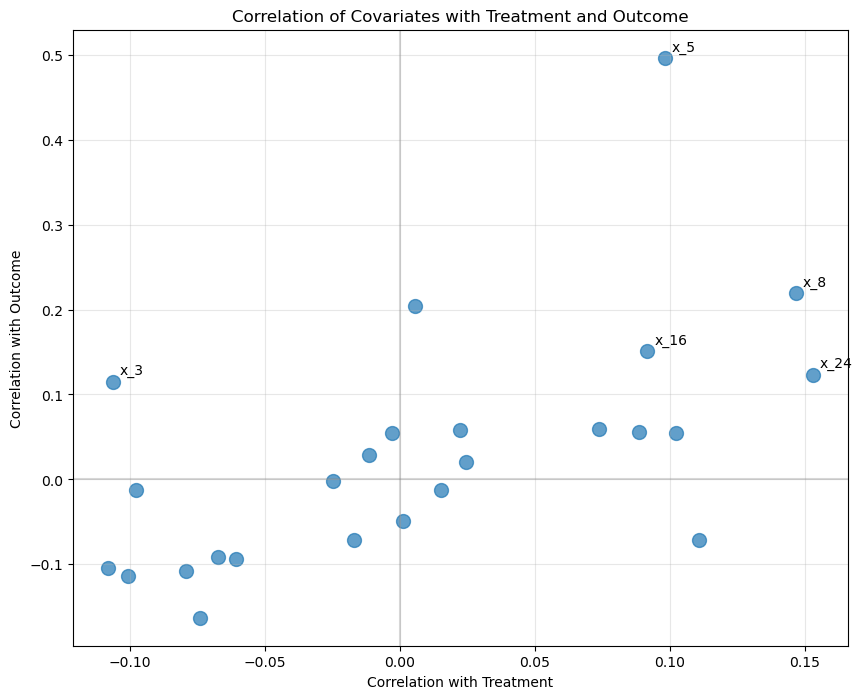

In [16]:
# Let's identify which variables might be important confounders
# We'll measure the association between each covariate and both treatment and outcome

# Calculate correlations
corr_with_treatment = {}
corr_with_outcome = {}

for cov in covariate_vars:
    # For binary treatment, we use point-biserial correlation (equivalent to Pearson for binary)
    corr_with_treatment[cov] = np.corrcoef(ihdp_data[treatment_var], ihdp_data[cov])[0, 1]
    corr_with_outcome[cov] = np.corrcoef(ihdp_data[outcome_var], ihdp_data[cov])[0, 1]

# Convert to DataFrame for easier visualization
confounders_df = pd.DataFrame({
    'Covariate': covariate_vars,
    'Corr_with_Treatment': [corr_with_treatment[cov] for cov in covariate_vars],
    'Corr_with_Outcome': [corr_with_outcome[cov] for cov in covariate_vars],
    'Potential_Confounder': [abs(corr_with_treatment[cov]) > 0.1 and abs(corr_with_outcome[cov]) > 0.1 
                             for cov in covariate_vars]
})

# Sort by strength of confounding (product of absolute correlations)
confounders_df['Confounding_Strength'] = abs(confounders_df['Corr_with_Treatment']) * \
                                          abs(confounders_df['Corr_with_Outcome'])
confounders_df = confounders_df.sort_values('Confounding_Strength', ascending=False)

# Display the top potential confounders
print("Top Potential Confounders:")
print(confounders_df.head(10))

# Visualize the correlations
plt.figure(figsize=(10, 8))
plt.scatter(confounders_df['Corr_with_Treatment'], 
            confounders_df['Corr_with_Outcome'],
            s=100, alpha=0.7)

# Add labels for top confounders
for i, row in confounders_df.head(5).iterrows():
    plt.annotate(row['Covariate'], 
                 (row['Corr_with_Treatment'], row['Corr_with_Outcome']),
                 xytext=(5, 5), textcoords='offset points')

plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
plt.title('Correlation of Covariates with Treatment and Outcome')
plt.xlabel('Correlation with Treatment')
plt.ylabel('Correlation with Outcome')
plt.grid(True, alpha=0.3)
plt.show()

**Analysis:** Variables in the upper right and lower left quadrants with larger magnitudes are the strongest confounders, as they have strong correlations with both treatment and outcome. These variables are crucial to control for in our causal analysis.

### 3.3 Identification Strategy

> 🔍 **Step 3**: Identify assumptions needed to estimate causal effects

To move from association to causation, we need to make certain assumptions:

#### Key Causal Assumptions

1. **Unconfoundedness/Ignorability**: The potential outcomes are independent of treatment assignment given the observed covariates.
   $$ (Y(0), Y(1)) \perp T | X $$

2. **Positivity/Overlap**: Every unit has a non-zero probability of receiving either treatment condition.
   $$ 0 < P(T=1|X=x) < 1 \text{ for all } x \text{ with } P(X=x) > 0 $$

3. **Stable Unit Treatment Value Assumption (SUTVA)**:
   - No interference between units
   - No hidden variations of treatments

Let's check the positivity assumption for the IHDP dataset:

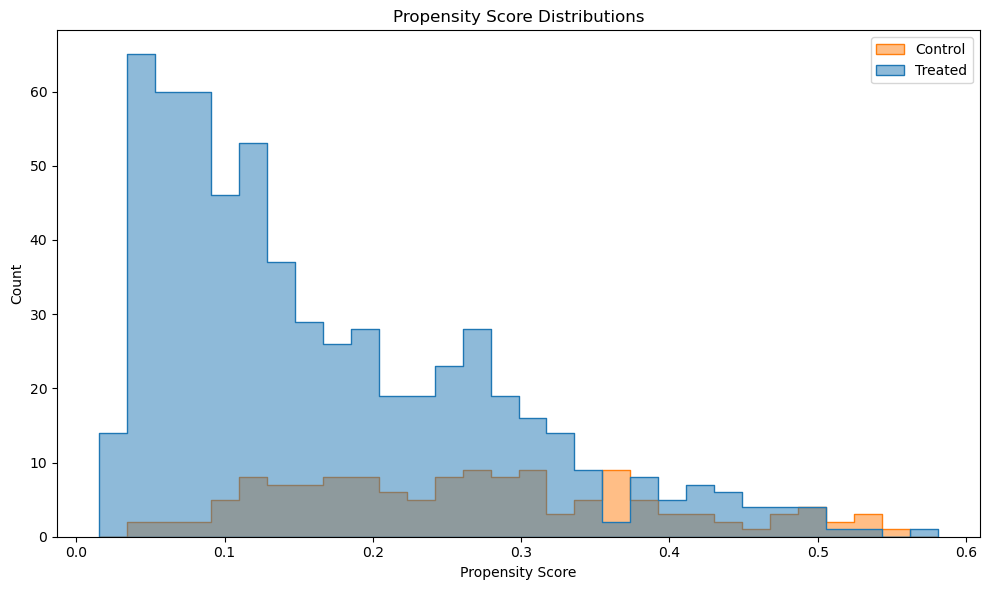

Percentage of units with extreme propensity scores: 8.18%
Treated group propensity range: [0.0395, 0.5482]
Control group propensity range: [0.0152, 0.5812]
Common support region: [0.0395, 0.5482]
Percentage of units in common support: 96.51%


In [17]:
# Estimate propensity scores to check the positivity assumption
from sklearn.linear_model import LogisticRegression

# Fit a logistic regression model to estimate propensity scores
propensity_model = LogisticRegression(max_iter=1000)
propensity_model.fit(ihdp_data[covariate_vars], ihdp_data[treatment_var])

# Predict propensity scores
ihdp_data['propensity_score'] = propensity_model.predict_proba(ihdp_data[covariate_vars])[:, 1]

# Plot the distribution of propensity scores for treated and control groups
plt.figure(figsize=(10, 6))
sns.histplot(data=ihdp_data, x='propensity_score', hue=treatment_var, 
             bins=30, alpha=0.5, element="step", common_norm=False)
plt.title('Propensity Score Distributions')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend(['Control', 'Treated'])
plt.tight_layout()
plt.show()

# Check for extreme propensity scores
extreme_propensity = (ihdp_data['propensity_score'] < 0.05) | (ihdp_data['propensity_score'] > 0.95)
print(f"Percentage of units with extreme propensity scores: {100 * extreme_propensity.mean():.2f}%")

# Check for the overlap assumption
treated_min = ihdp_data.loc[ihdp_data[treatment_var] == 1, 'propensity_score'].min()
treated_max = ihdp_data.loc[ihdp_data[treatment_var] == 1, 'propensity_score'].max()
control_min = ihdp_data.loc[ihdp_data[treatment_var] == 0, 'propensity_score'].min()
control_max = ihdp_data.loc[ihdp_data[treatment_var] == 0, 'propensity_score'].max()

print(f"Treated group propensity range: [{treated_min:.4f}, {treated_max:.4f}]")
print(f"Control group propensity range: [{control_min:.4f}, {control_max:.4f}]")

# Common support region
common_support_min = max(treated_min, control_min)
common_support_max = min(treated_max, control_max)
print(f"Common support region: [{common_support_min:.4f}, {common_support_max:.4f}]")
print(f"Percentage of units in common support: {100 * ((ihdp_data['propensity_score'] >= common_support_min) & (ihdp_data['propensity_score'] <= common_support_max)).mean():.2f}%")

**Analysis:** The propensity score distributions show the probability of receiving treatment given covariates. Overlap between treated and control groups suggests the positivity assumption is reasonable, but areas with little overlap may lead to less reliable causal estimates.

#### From Causal to Statistical Estimand

Once we've established our causal assumptions, we need to translate our causal estimand (ATE) into a statistical estimand that can be estimated from observed data.

Under the unconfoundedness assumption, the ATE can be estimated as:

$$ ATE = E[Y(1) - Y(0)] = E_X[E[Y|T=1, X] - E[Y|T=0, X]] $$

This forms the basis for many causal inference methods.

### 3.4 Estimation Methods

> ⚙️ **Step 4**: Implement estimation strategies

Various methods can be used to estimate causal effects. We'll categorize them into several groups:

#### 1. Regression-Based Methods

In [18]:
# Simple regression adjustment
from sklearn.linear_model import LinearRegression

# We'll use a simple linear regression model
reg_model = LinearRegression()

# Add interaction terms between treatment and covariates
X = ihdp_data[covariate_vars].copy()
X['treatment'] = ihdp_data[treatment_var]

# Add interaction terms for first few covariates (for simplicity)
for cov in covariate_vars[:5]:  # Just use first 5 covariates for interactions
    X[f'{cov}_x_treatment'] = X[cov] * X['treatment']

# Fit the model
reg_model.fit(X, ihdp_data[outcome_var])

# Get the treatment effect coefficient
treatment_coef = reg_model.coef_[X.columns.get_loc('treatment')]
print(f"Estimated ATE using regression adjustment: {treatment_coef:.4f}")
print(f"True ATE: {true_ate:.4f}")
print(f"Bias: {treatment_coef - true_ate:.4f}")

Estimated ATE using regression adjustment: 3.9194
True ATE: 4.0166
Bias: -0.0972


#### 2. Propensity Score Methods

Propensity score methods estimate the probability of treatment given covariates, then use these scores to adjust for confounding.

In [19]:
# We already estimated propensity scores above

# 2.1 Inverse Probability Weighting (IPW)
# Calculate IPW weights
ihdp_data['ipw'] = np.where(
    ihdp_data[treatment_var] == 1,
    1 / ihdp_data['propensity_score'],
    1 / (1 - ihdp_data['propensity_score'])
)

# Trim extreme weights
q99 = np.percentile(ihdp_data['ipw'], 99)
ihdp_data['ipw_trimmed'] = np.minimum(ihdp_data['ipw'], q99)

# Calculate the IPW estimate
ipw_ate = (ihdp_data[ihdp_data[treatment_var] == 1]['ipw_trimmed'] * ihdp_data[ihdp_data[treatment_var] == 1][outcome_var]).sum() / ihdp_data[ihdp_data[treatment_var] == 1]['ipw_trimmed'].sum() - \
          (ihdp_data[ihdp_data[treatment_var] == 0]['ipw_trimmed'] * ihdp_data[ihdp_data[treatment_var] == 0][outcome_var]).sum() / ihdp_data[ihdp_data[treatment_var] == 0]['ipw_trimmed'].sum()

print(f"Estimated ATE using IPW: {ipw_ate:.4f}")
print(f"True ATE: {true_ate:.4f}")
print(f"Bias: {ipw_ate - true_ate:.4f}")

# 2.2 Propensity Score Matching
from sklearn.neighbors import NearestNeighbors

# Match treated units to control units based on propensity scores
treated_indices = ihdp_data[ihdp_data[treatment_var] == 1].index
control_indices = ihdp_data[ihdp_data[treatment_var] == 0].index

treated_ps = ihdp_data.loc[treated_indices, 'propensity_score'].values.reshape(-1, 1)
control_ps = ihdp_data.loc[control_indices, 'propensity_score'].values.reshape(-1, 1)

# Find nearest neighbor matches
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_ps)
distances, indices = nn.kneighbors(treated_ps)

# Get matched control indices
matched_control_indices = control_indices[indices.flatten()]

# Calculate treatment effect
matched_ate = ihdp_data.loc[treated_indices, outcome_var].mean() - \
              ihdp_data.loc[matched_control_indices, outcome_var].mean()

print(f"Estimated ATE using propensity score matching: {matched_ate:.4f}")
print(f"True ATE: {true_ate:.4f}")
print(f"Bias: {matched_ate - true_ate:.4f}")

Estimated ATE using IPW: 4.0346
True ATE: 4.0166
Bias: 0.0180
Estimated ATE using propensity score matching: 3.8395
True ATE: 4.0166
Bias: -0.1771


#### 3. Doubly Robust Methods

Doubly robust methods combine outcome modeling and propensity score weighting, providing protection against misspecification of either model.

In [20]:
# Implement Augmented Inverse Probability Weighting (AIPW)
# First, we need outcome models for both treatment groups
from sklearn.linear_model import LinearRegression

# Split data into treated and control
treated_data = ihdp_data[ihdp_data[treatment_var] == 1]
control_data = ihdp_data[ihdp_data[treatment_var] == 0]

# Fit outcome models for treated and control groups
treated_model = LinearRegression()
treated_model.fit(treated_data[covariate_vars], treated_data[outcome_var])

control_model = LinearRegression()
control_model.fit(control_data[covariate_vars], control_data[outcome_var])

# Predict potential outcomes for all units
ihdp_data['y_pred_1'] = treated_model.predict(ihdp_data[covariate_vars])
ihdp_data['y_pred_0'] = control_model.predict(ihdp_data[covariate_vars])

# Calculate AIPW estimator
treated_correction = (ihdp_data[treatment_var] * (ihdp_data[outcome_var] - ihdp_data['y_pred_1'])) / ihdp_data['propensity_score']
control_correction = ((1 - ihdp_data[treatment_var]) * (ihdp_data[outcome_var] - ihdp_data['y_pred_0'])) / (1 - ihdp_data['propensity_score'])

aipw_ate = (ihdp_data['y_pred_1'] - ihdp_data['y_pred_0']).mean() + treated_correction.mean() - control_correction.mean()

print(f"Estimated ATE using AIPW: {aipw_ate:.4f}")
print(f"True ATE: {true_ate:.4f}")
print(f"Bias: {aipw_ate - true_ate:.4f}")

Estimated ATE using AIPW: 3.9809
True ATE: 4.0166
Bias: -0.0357


#### 4. Machine Learning-Based Methods

Machine learning methods can capture complex relationships between variables without requiring parametric assumptions.

In [27]:
# Example of using a simple ML-based approach: T-Learner
from sklearn.ensemble import RandomForestRegressor

# T-Learner: Fit separate models for treated and control groups
t_treated_model = RandomForestRegressor(n_estimators=100, random_state=42)
t_treated_model.fit(treated_data[covariate_vars], treated_data[outcome_var])

t_control_model = RandomForestRegressor(n_estimators=100, random_state=42)
t_control_model.fit(control_data[covariate_vars], control_data[outcome_var])

# Predict potential outcomes for all units
ihdp_data['y_pred_t1'] = t_treated_model.predict(ihdp_data[covariate_vars])
ihdp_data['y_pred_t0'] = t_control_model.predict(ihdp_data[covariate_vars])

# Calculate T-Learner ATE
t_learner_ate = (ihdp_data['y_pred_t1'] - ihdp_data['y_pred_t0']).mean()

print(f"Estimated ATE using T-Learner: {t_learner_ate:.4f}")
print(f"True ATE: {true_ate:.4f}")
print(f"Bias: {t_learner_ate - true_ate:.4f}")

# Example of a more advanced method: Causal Forest (requires econml or causalml)
# For illustration, we'll use causalml if available

from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV, LogisticRegression

# Initialize the Causal Forest with discrete_treatment=True
cf = CausalForestDML(
    model_y=LassoCV(),
    model_t=LogisticRegression(max_iter=1000),
    discrete_treatment=True,  # Marks treatment as binary/discrete
    n_estimators=100,
    random_state=42
)

# Fit the model with outcome, treatment, and covariate features
cf.fit(ihdp_data[outcome_var],
       ihdp_data[treatment_var],
       X=ihdp_data[covariate_vars])

# Get treatment effects
cf_te = cf.effect(X=ihdp_data[covariate_vars])
cf_ate = cf_te.mean()

print(f"Estimated ATE using Causal Forest: {cf_ate:.4f}")
print(f"True ATE: {true_ate:.4f}")
print(f"Bias: {cf_ate - true_ate:.4f}")


Estimated ATE using T-Learner: 3.9387
True ATE: 4.0166
Bias: -0.0780
Estimated ATE using Causal Forest: 3.9355
True ATE: 4.0166
Bias: -0.0811


### 3.5 Evaluation and Validation

> 📏 **Step 5**: Assess the quality of causal estimates

Evaluating causal estimates is challenging because we usually can't observe the ground truth. However, in the IHDP dataset, we have the advantage of knowing the true causal effects.

Let's compare different methods using several metrics:

Comparison of Causal Inference Methods:
                        Method  ATE Estimate      Bias  Absolute Bias  \
0  Naive (Difference in Means)      4.027154  0.010511       0.010511   
2                          IPW      4.034594  0.017950       0.017950   
4                         AIPW      3.980939 -0.035704       0.035704   
5               T-Learner (RF)      3.938680 -0.077963       0.077963   
6                Causal Forest      3.935521 -0.081123       0.081123   
1        Regression Adjustment      3.919396 -0.097247       0.097247   
3    Propensity Score Matching      3.839537 -0.177106       0.177106   

   Relative Bias (%)  
0           0.261674  
2           0.446902  
4           0.888909  
5           1.940996  
6           2.019662  
1           2.421097  
3           4.409312  


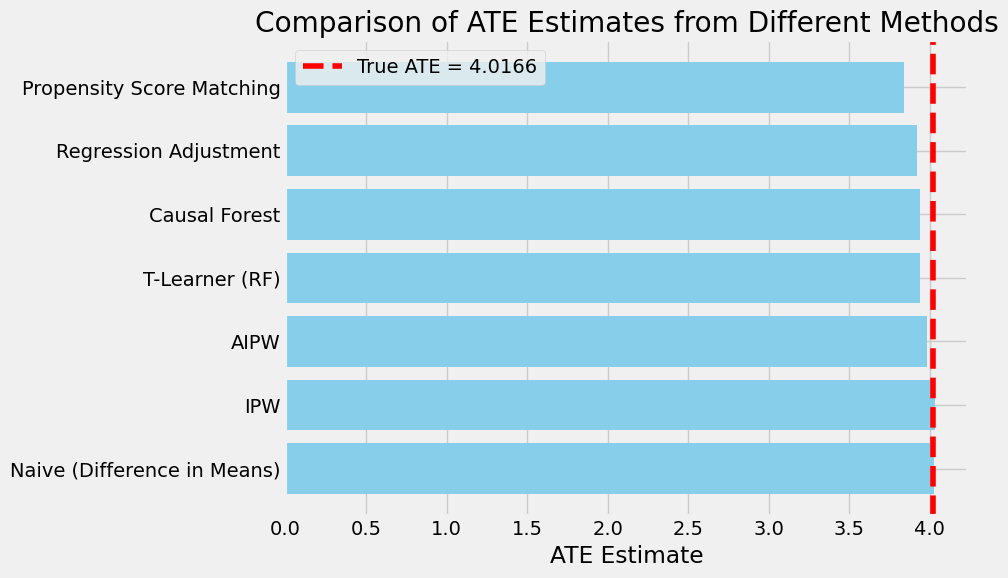

In [28]:
# Create a DataFrame to compare methods
methods = [
    'Naive (Difference in Means)',
    'Regression Adjustment',
    'IPW',
    'Propensity Score Matching',
    'AIPW',
    'T-Learner (RF)'
]

estimates = [
    naive_ate,
    treatment_coef,
    ipw_ate,
    matched_ate,
    aipw_ate,
    t_learner_ate
]

if 'cf_ate' in locals():  # If we ran the Causal Forest
    methods.append('Causal Forest')
    estimates.append(cf_ate)

# Calculate metrics
biases = [est - true_ate for est in estimates]
abs_biases = [abs(bias) for bias in biases]
rel_biases = [abs(bias / true_ate) * 100 for bias in biases]

# Create the comparison DataFrame
comparison_df = pd.DataFrame({
    'Method': methods,
    'ATE Estimate': estimates,
    'Bias': biases,
    'Absolute Bias': abs_biases,
    'Relative Bias (%)': rel_biases
})

# Sort by absolute bias
comparison_df = comparison_df.sort_values('Absolute Bias')

# Print comparison
print("Comparison of Causal Inference Methods:")
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.barh(y=comparison_df['Method'], width=comparison_df['ATE Estimate'], color='skyblue')
plt.axvline(x=true_ate, color='red', linestyle='--', label=f'True ATE = {true_ate:.4f}')
plt.xlabel('ATE Estimate')
plt.title('Comparison of ATE Estimates from Different Methods')
plt.legend()
plt.tight_layout()
plt.show()

**Analysis:** This comparison shows how different causal inference methods perform. Methods with lower bias provide estimates closer to the true ATE. In practice, where the true effect is unknown, we'd rely on theoretical properties of the methods and sensitivity analysis.

#### Sensitivity Analysis

Sensitivity analysis helps assess how robust our estimates are to violations of key assumptions.

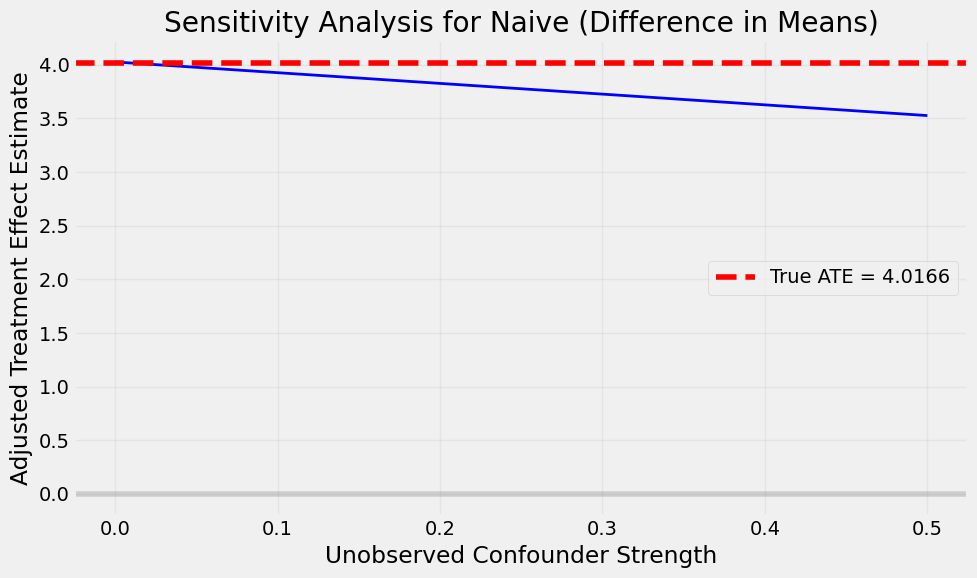

The estimate from Naive (Difference in Means) would not change sign even with a strong unobserved confounder


In [29]:
# Simple sensitivity analysis for unobserved confounding
# We'll simulate the impact of an unobserved confounder with varying strength

def sensitivity_analysis(effect_estimate, n_sims=50, max_confounder_strength=0.5):
    """
    Perform a simple sensitivity analysis for unobserved confounding
    
    Parameters:
    -----------
    effect_estimate: float
        The estimated treatment effect
    n_sims: int
        Number of simulation points
    max_confounder_strength: float
        Maximum strength of confounding to simulate
        
    Returns:
    --------
    pandas.DataFrame with sensitivity results
    """
    confounder_strengths = np.linspace(0, max_confounder_strength, n_sims)
    adjusted_estimates = []
    
    for strength in confounder_strengths:
        # Simple linear adjustment for an unobserved confounder
        adjusted_est = effect_estimate - strength
        adjusted_estimates.append(adjusted_est)
    
    results = pd.DataFrame({
        'Confounder_Strength': confounder_strengths,
        'Adjusted_Estimate': adjusted_estimates
    })
    
    return results

# Let's apply sensitivity analysis to our best estimate (whichever had lowest bias)
best_method_idx = comparison_df['Absolute Bias'].idxmin()
best_method = comparison_df.loc[best_method_idx, 'Method']
best_estimate = comparison_df.loc[best_method_idx, 'ATE Estimate']

sensitivity_results = sensitivity_analysis(best_estimate, n_sims=100)

# Plot the sensitivity analysis
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_results['Confounder_Strength'], 
         sensitivity_results['Adjusted_Estimate'],
         color='blue', linewidth=2)
plt.axhline(y=true_ate, color='red', linestyle='--', 
            label=f'True ATE = {true_ate:.4f}')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Find where the adjusted estimate crosses zero
if min(sensitivity_results['Adjusted_Estimate']) < 0 < max(sensitivity_results['Adjusted_Estimate']):
    zero_crossing = np.interp(0, sensitivity_results['Adjusted_Estimate'][::-1], 
                            sensitivity_results['Confounder_Strength'][::-1])
    plt.axvline(x=zero_crossing, color='green', linestyle=':', 
                label=f'Sign change at strength = {zero_crossing:.4f}')

plt.title(f'Sensitivity Analysis for {best_method}')
plt.xlabel('Unobserved Confounder Strength')
plt.ylabel('Adjusted Treatment Effect Estimate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"The estimate from {best_method} would change sign if there was an unobserved confounder with strength greater than {zero_crossing:.4f}" if 'zero_crossing' in locals() else f"The estimate from {best_method} would not change sign even with a strong unobserved confounder")

**Analysis:** The sensitivity analysis shows how the estimated treatment effect would change if there were an unobserved confounder of varying strength. When the adjusted estimate crosses zero, it indicates how strong an unobserved confounder would need to be to change the direction of the estimated effect.

## Resources and References

- Pearl, J. (2009). Causality: Models, Reasoning, and Inference. Cambridge University Press.
- Hernán, M. A., & Robins, J. M. (2020). Causal Inference: What If. Chapman & Hall/CRC.
- Hill, J. L. (2011). Bayesian nonparametric modeling for causal inference. Journal of Computational and Graphical Statistics.
- [DoWhy: A Library for Causal Inference](https://microsoft.github.io/dowhy/)
- [EconML: A Library for ML-Based Causal Inference](https://github.com/microsoft/EconML)
- [CausalML: A Library for Uplift Modeling and Causal Inference](https://github.com/uber/causalml)